In [ ]:
#Clustering

import os
os.chdir('...')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import gdown
import sankey
import anndata
import pandas as pd
from pySankey.sankey import sankey
from matplotlib.pyplot import rc_context
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(5, 5))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=12)

In [2]:
directory = '/data/kkovacs/Python'

In [3]:
Full_adata = sc.read(directory + "/Data/Full_adata_h_pre.h5ad")

In [4]:
print(Full_adata)

AnnData object with n_obs × n_vars = 174532 × 42186
    obs: 'nCount_covid', 'nFeature_covid', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'CellStatus', 'pANN_0.25_0.09_241', 'DF.classifications_0.25_0.09_241', 'DoubletStatus', 'pANN_0.25_0.09_520', 'DF.classifications_0.25_0.09_520', 'pANN_0.25_0.09_148', 'DF.classifications_0.25_0.09_148', 'pANN_0.25_0.09_368', 'DF.classifications_0.25_0.09_368', 'pANN_0.25_0.09_1110', 'DF.classifications_0.25_0.09_1110', 'pANN_0.25_0.09_33', 'DF.classifications_0.25_0.09_33', 'pANN_0.25_0.09_1015', 'DF.classifications_0.25_0.09_1015', 'nGene', 'nUMI', 'Group', 'res.0', 'res.0.1', 'res.0.2', 'res.0.3', 'res.0.4', 'res.0.5', 'res.0.6', 'res.0.7', 'res.0.8', 'res.0.9', 'res.1', 'seurat_clusters', 'infection', 'Sample.Gender', 'percent.hb', 'percent.rp', 'cluster_labels_res.0.4', 'predicted.classification_Angelidis.score', 'predicted.classification_Angelidis', 'mouseRNA.labels', 'immgen.labels', 'RNA_snn_res.0.3', 'RNA_snn_res.0.4', 'RNA_s

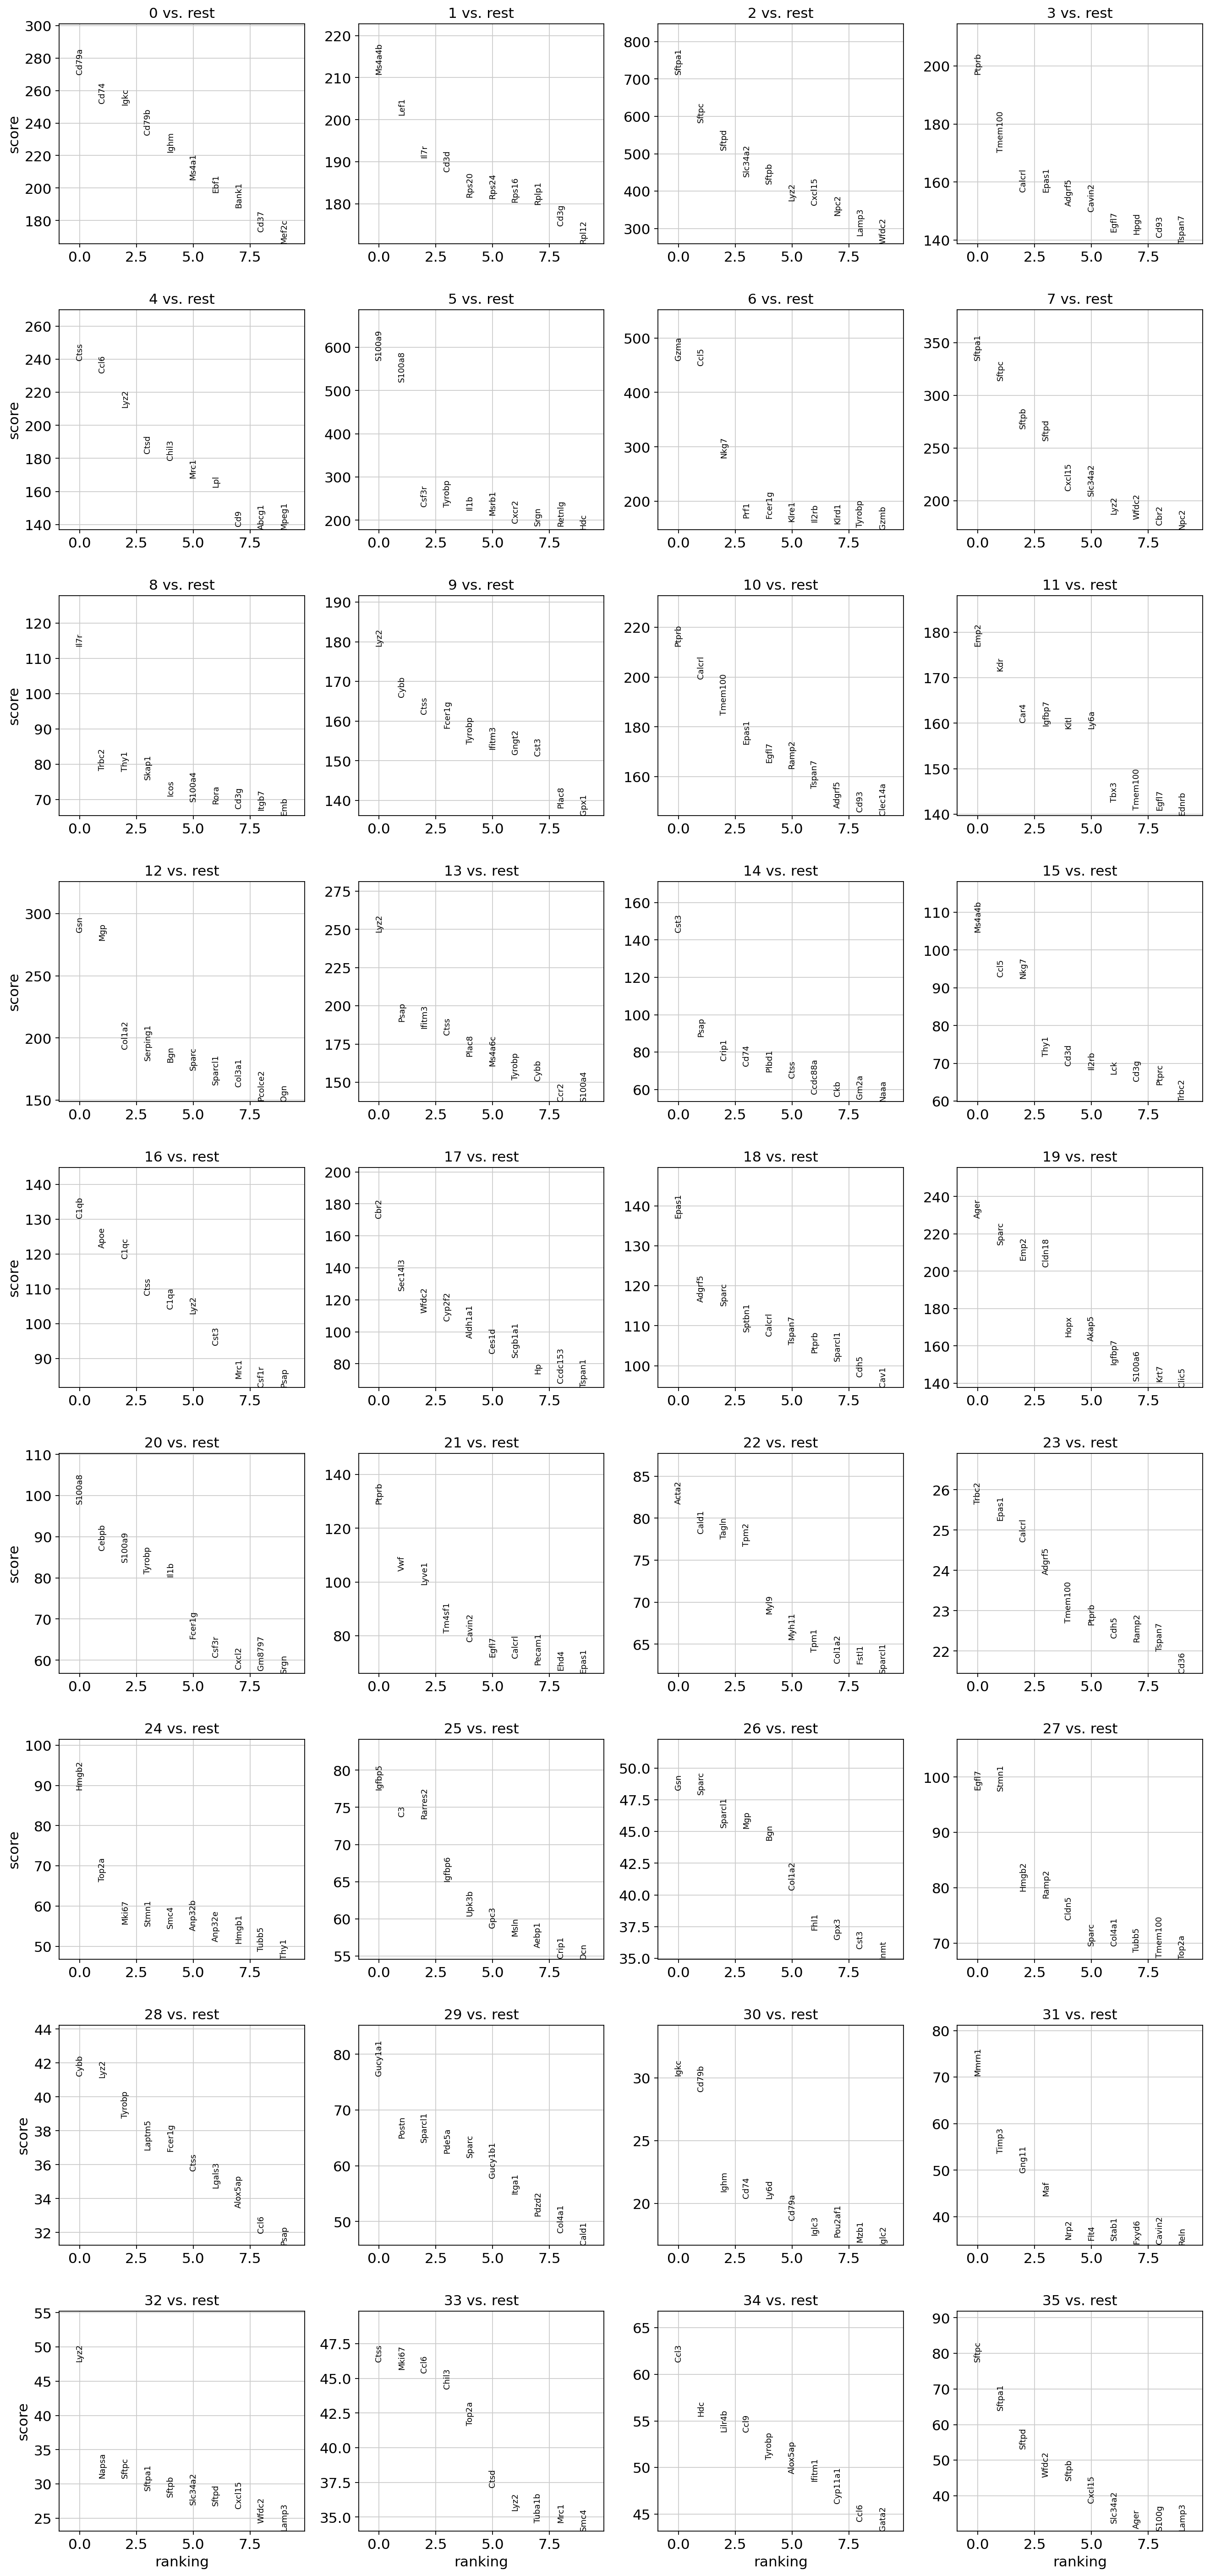

In [7]:
import warnings

# To filter out all warnings
warnings.filterwarnings("ignore")

Full_adata.layers['raw'] = Full_adata.X.copy()
sc.pp.normalize_total(Full_adata, target_sum=1e4)
sc.pp.log1p(Full_adata)
Full_adata.raw = Full_adata
Full_adata.layers['norm'] = Full_adata.X.copy()


Full_adata.uns['log1p']["base"] = None
sc.tl.rank_genes_groups(Full_adata, 'leiden_2', method='t-test')
sc.pl.rank_genes_groups(Full_adata, n_genes=10, sharey=False,save='FullGenes.png')
warnings.resetwarnings()


In [ ]:
Using some gene signatures for multiple celltypes in hopes of being identify any clusters that 
could be mis-annotated

In [ ]:
sc.tl.score_genes(Full_adata,redblood, score_name='redblood')
sc.tl.score_genes(Full_adata,Int, score_name='Int')
sc.tl.score_genes(Full_adata,CD4, score_name='CD4')
sc.tl.score_genes(Full_adata,Bcell, score_name='Bcell')
sc.tl.score_genes(Full_adata,Cap, score_name='Cap')
sc.tl.score_genes(Full_adata,AT1, score_name='AT1')
sc.tl.score_genes(Full_adata,AT2, score_name='AT2')
sc.tl.score_genes(Full_adata,Basal, score_name='Basal')
sc.tl.score_genes(Full_adata,Club, score_name='Club')

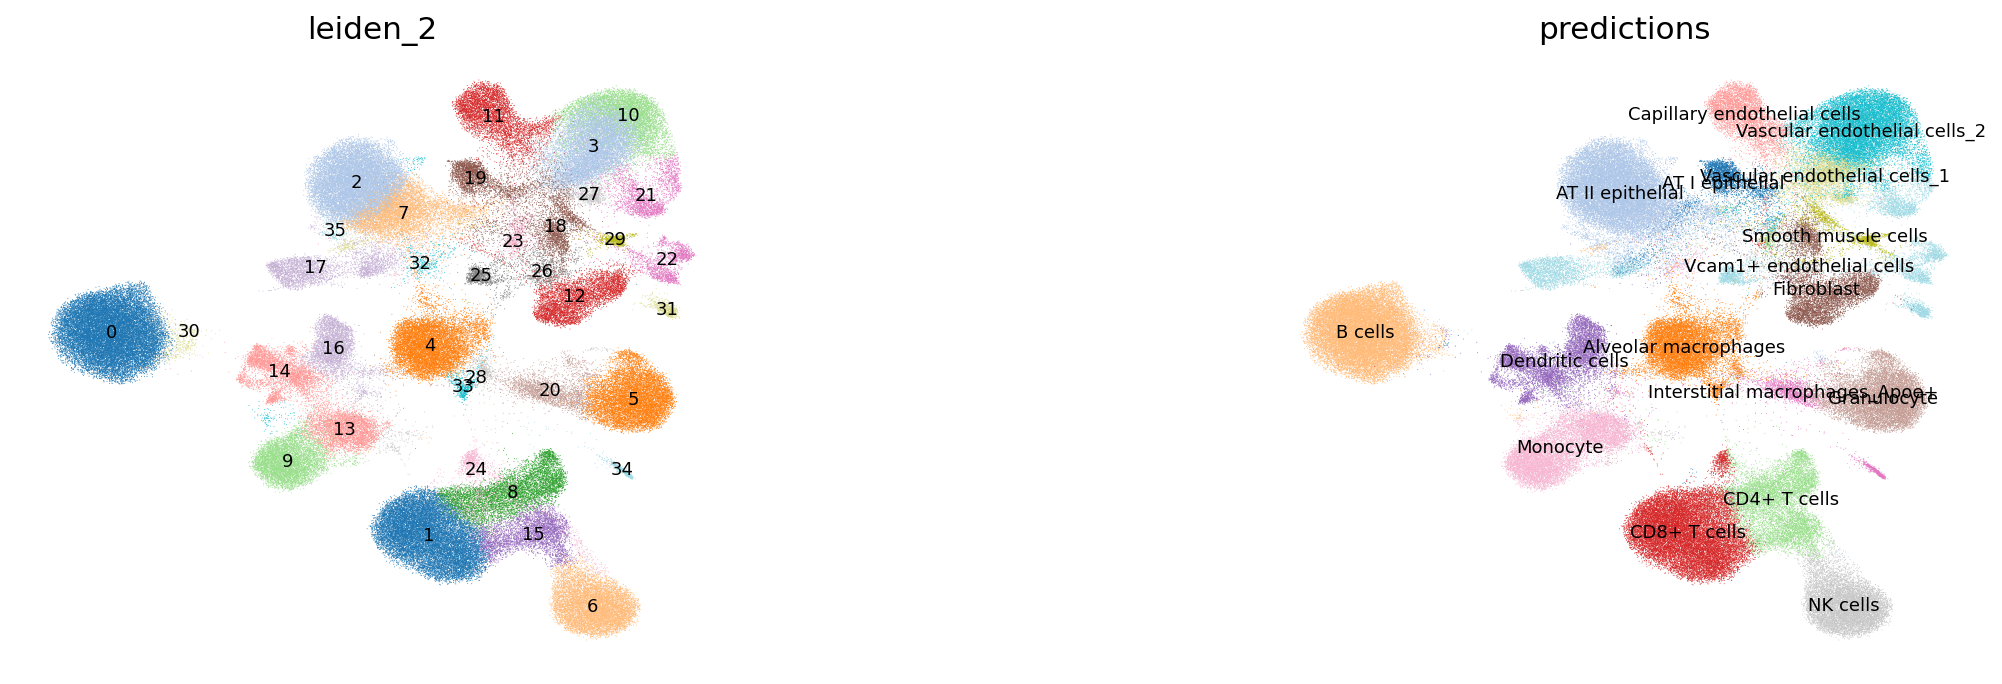

In [6]:
sc.pl.umap(
    Full_adata,
    use_raw= False,
    color=['leiden_2','predictions'],
    frameon=False,#cmap = 'bwr', vmin=-1, vmax=1,\
    wspace=0.6, 
    legend_loc = 'on data',
    legend_fontweight = 'light',
    legend_fontsize = 'xx-small',
    save = 'pred.png',
    palette = 'tab20'
)

In [ ]:
Taking each predictions celltype, we can recluster each to find if there are any mis-anatated 
cells.And used to find any different sub celltypes within them

Creating a new HVG set for the subset celltype allows for the finding of small differences 
between each sub-cluster

In [ ]:
subset_bcell = adata[adata.obs['leiden_2'] == 'B cells', :].copy()
check_bcell = adata[adata.obs['leiden_2'] == 'B cells', :].copy()


top_genes_dict = {}

# Identify the top 6000 highly variable genes for each study
for study in np.unique(subset_bcell.obs['study']):
    study_subset = subset_bcell[subset_bcell.obs['study'] == study].copy()
    sc.pp.highly_variable_genes(study_subset, n_top_genes=6000)
    top_genes_dict[study] = study_subset.var_names[study_subset.var['highly_variable']]

from itertools import combinations
vnames = [set(genes) for genes in top_genes_dict.values()]

# Calculate the intersection using combinations
gene = set()
combo_size = len(vnames) + 1

while len(gene) < 2000 and combo_size > 0:
    combo_size -= 1
    
    for combo in combinations(range(len(vnames)), combo_size):
        intersection = vnames[combo[0]]
        
        for i in combo[1:]:
            intersection = intersection & vnames[i]
        
        gene = gene.union(intersection)
        
        if len(gene) >= 2000:
            break
        
        print(" and ".join(f"Set{i+1}" for i in combo), "=", len(intersection))

# Get the final list of 2000 genes
final_gene_list = list(gene)[:2000]

subset_bcell = subset_bcell[:,final_gene_list]
sc.pp.neighbors(subset_bcell, use_rep = 'X_MLCA')
sc.tl.umap(subset_bcell)
sc.tl.leiden(subset_bcell, key_added='clusters2', resolution=0.2)

check_bcell.obsm['X_umap'] = subset_bcell.obsm['X_umap']
check_bcell.obs['clusters2'] = subset_bcell.obs['clusters2']

# Plot the UMAP for the current cell type
sc.pl.umap(subset_bcell, use_raw=False, legend_loc='on data', legend_fontsize='xx-small',
		   legend_fontweight='normal', color=['predictions','clusters2','study',\
		   'platform'],
		   save=f"umap_bcell.png")

check_bcell.X.data = check_bcell.layers['norm'].data.copy()
check_bcell.uns['log1p']["base"] = None
sc.tl.rank_genes_groups(check_bcell, 'clusters2', method='t-test')
sc.pl.rank_genes_groups(check_bcell, n_genes=15, sharey=False,save=f'clusters2_bcell.png')

In [ ]:
This is then repeated for each celltype in the predictions

Then the healthy is saved, the disease is just integrated and moved into the MLCA script